# Fit an euler pole to GPS data

#### Eric Lindsey, 2022

In [51]:
#these two lines make sure our functions will get re-loaded if it changes
%load_ext autoreload
%autoreload 2
# extra line that makes sure our plots appear in the same notebook
%matplotlib inline

# user defined modules
import gps_data
import euler_calc
import geod_transform

# python modules
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# define a function to keep all our 'standard' background map plot commands
def plot_my_custom_map(west,east,south,north):
    fig = plt.figure(figsize=(10, 10))
    m = Basemap(llcrnrlon=west,llcrnrlat=south,urcrnrlon=east,urcrnrlat=north,
                resolution='h', projection='cyl', lat_0 = 21.5, lon_0 = 95.0)
    #merc is for the projection Mercator
    m.drawcoastlines()
    m.drawcountries(color='black')
    # draw parallels
    m.drawparallels(np.arange(-90,90,5),labels=[1,0,0,1],linewidth=0.5)
    # draw meridians
    m.drawmeridians(np.arange(-180,180,5),labels=[1,0,0,1],linewidth=0.5)

    return fig,m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


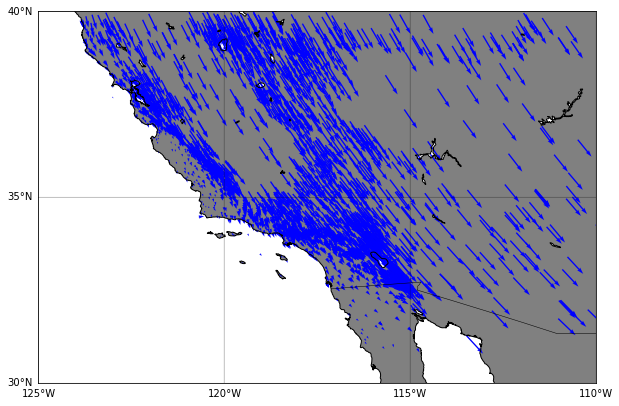

In [52]:
# load and plot initial dataset - example data are compiled by Kreemer et al., 2014

# setup the basemap
west=235
east=250
south=30
north=40
fig,m = plot_my_custom_map(west,east,south,north)

# options for a background color:
#m.shadedrelief()
#m.etopo()
#m.bluemarble()
m.fillcontinents('gray',zorder=-1) 
# note, zorder is needed to make the color appear in the background (lower z value)

# load and plot GPS data
GPS = gps_data.GPSData()
GPS.load_2d_data('ca_gps.gmt')

m.quiver(GPS.lon,GPS.lat,GPS.vE,GPS.vN,color='b', scale=1e3)
plt.show()

# optionally save map as a PDF file
#plt.savefig('gps_vels.pdf',dpi=50,bbox_inches='tight')


[ 49.3194862  -76.64657405   0.75368854] 0.7110203505794074
[ 49.18421831 -76.67709757   0.74862684] 0.4588778561977442
[ 49.15357101 -76.6125992    0.74317513] 0.31493844210028565
[ 49.01375313 -77.29739747   0.75040155] 0.2927372881400287
[ 48.89114439 -77.73084502   0.75516198] 0.3578011246138269
[ 48.86178249 -77.90160169   0.75608089] 0.3587732377607598
[ 48.76721118 -78.43330656   0.76189903] 0.34465439369481027
[ 48.72508364 -78.64641196   0.76353175] 0.2594658697232496
[ 48.69682164 -78.90252173   0.76676952] 0.2608737575408351
[ 48.63838144 -79.24079651   0.77182007] 0.2684295270479818
[ 48.50203086 -79.93552074   0.78374194] 0.2835660703114893
[ 48.41966966 -80.36753736   0.79060737] 0.28674197211871755
[ 48.37133669 -80.61526209   0.79469021] 0.30274918846284665
[ 48.35808108 -80.67770426   0.79577332] 0.2983446140023614
[ 48.3569156  -80.68293548   0.7958716 ] 0.30512786698015126
finishing after 15 iterations
identified euler pole (lat,lon, deg/myr) [ 48.3569156  -80.682935

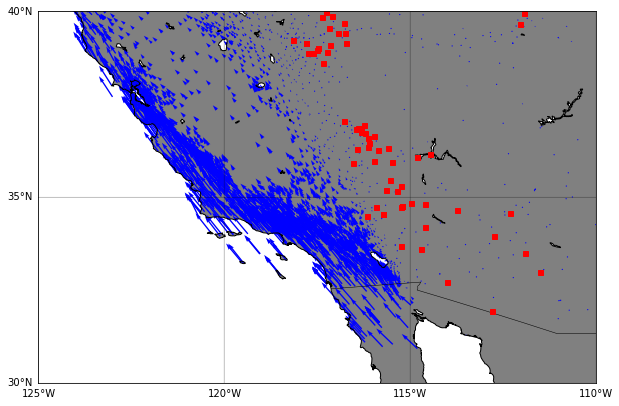

In [55]:
# Select sites on stable NA plate and estimate an euler pole

# bounding box for initial sites to use in pole estimation. Should be at least 3 sites
latmin=35
latmax=37
lonmin=248
lonmax=250

# use only data with uncertainty less than this value
sigthres=1

#criteria for identifying sites that are "really" in the block (rotating rigidly together)
mthres=1.5
maxiter=30

# get ID numbers of sites inside the box and with low enough uncertainty
blockids=np.where(np.logical_and(GPS.sigE<sigthres, np.logical_and(GPS.sigN<sigthres, 
                  np.logical_and(GPS.lat>latmin,np.logical_and(GPS.lat<latmax,np.logical_and(GPS.lon>lonmin,GPS.lon<lonmax))))))[0]

blockids,blockpole=euler_calc.identify_block(GPS,blockids,sig_thres=sigthres,misfit_thres=mthres,maxiter=maxiter)
   
print("identified euler pole (lat,lon, deg/myr)", blockpole)

#plot data on a map
fig,m = plot_my_custom_map(west,east,south,north)
m.fillcontinents('gray',zorder=-1) 

# plot rigidly rotating stations used in fit as red squares
m.plot(GPS.lon[blockids],GPS.lat[blockids],'rs',markersize=5)

# compute the predicted motion for this block relative to the original data
pred_e,pred_n=euler_calc.pole_velocity(GPS.lat,GPS.lon,blockpole[0],blockpole[1],blockpole[2]) 
resid=GPS.calc_resid(pred_e,pred_n)
misfits=GPS.calc_point_misfit(pred_e,pred_n)

#plot transformed velocities
m.quiver(GPS.lon,GPS.lat,GPS.vE - pred_e,GPS.vN - pred_n,color='blue',scale=1e3)

plt.show()
